<a href="https://colab.research.google.com/github/seanadrian56/image-classification/blob/main/Proyek_3(Akhir)_Image_Classification_Model_Deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Akhir:Image Classification Model Deployment

## Nama:Sean Adrian Lythio

## No.Regis:1494037162101-2278

## Email:seanadrian56@gmail.com

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"seanadrianlythio","key":"16f75f18fd307d34c1799dde82ba1d6e"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
 ! kaggle datasets list

ref                                                             title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
meirnizri/covid19-dataset                                       COVID-19 Dataset                                      5MB  2022-11-13 15:47:17           5946        180  1.0              
madhurpant/world-deaths-and-causes-1990-2019                    World Deaths and Causes (1990 - 2019)               442KB  2022-11-29 07:09:27            993         24  1.0              
thedevastator/jobs-dataset-from-glassdoor                       Salary Prediction                                     3MB  2022-11-16 13:52:31           3912         89  1.0              
thedevastator/how-much-sleep-do-americans-really-get        

In [ ]:
! kaggle datasets download -d viratkothari/animal10

100% 585M/585M [00:29<00:00, 24.5MB/s]
100% 585M/585M [00:29<00:00, 20.6MB/s]


In [ ]:
! mkdir animals
! unzip -qq animal10.zip -d animals
! ls animals

Animals-10


In [ ]:
! ls animals/Animals-10

butterfly  cat	chicken  cow  dog  elephant  horse  sheep  spider  squirrel


In [ ]:
import os

animals = os.path.join('/content/animals/Animals-10')

print(os.listdir(animals))

['sheep', 'chicken', 'spider', 'elephant', 'horse', 'squirrel', 'cow', 'cat', 'dog', 'butterfly']


In [ ]:
list_animals = os.listdir(animals)
print(list_animals)

['sheep', 'chicken', 'spider', 'elephant', 'horse', 'squirrel', 'cow', 'cat', 'dog', 'butterfly']


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
import numpy as np
import matplotlib.pyplot as plt
import pathlib

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    vertical_flip=True,
    horizontal_flip=True,
    validation_split=0.2,
    fill_mode='nearest'
)

In [ ]:
data_train = train_datagen.flow_from_directory(
    animals,
    target_size=(150,150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

data_val = train_datagen.flow_from_directory(
    animals,
    target_size=(150,150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 20947 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.


In [ ]:
pre_trained_model = MobileNetV2(weights="imagenet", include_top=False,
                                input_tensor=Input(shape=(150, 150, 3)))

for layer in pre_trained_model.layers:
    layer.trainable = False

last_output = pre_trained_model.output

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
x = tf.keras.layers.Flatten(name="flatten")(last_output)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.models.Model(pre_trained_model.input, x)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_Conv1[0][0]']           

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.92):
      print("\nAkurasi model telah mencapai >92%")
      self.model.stop_training = True

callback_model = myCallback()  

In [ ]:
int_lr = 1e-4
num_epochs = 40

optimizer = tf.optimizers.Adam(lr=int_lr)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(data_train, 
                    epochs=num_epochs,
                    validation_data=data_val, 
                    callbacks=[callback_model], 
                    verbose=2)

Epoch 1/40
655/655 - 175s - loss: 1.6746 - accuracy: 0.4308 - val_loss: 1.1876 - val_accuracy: 0.6061 - 175s/epoch - 268ms/step
Epoch 2/40
655/655 - 163s - loss: 1.2410 - accuracy: 0.5978 - val_loss: 1.0360 - val_accuracy: 0.6554 - 163s/epoch - 249ms/step
Epoch 3/40
655/655 - 162s - loss: 1.0298 - accuracy: 0.6526 - val_loss: 0.8487 - val_accuracy: 0.7047 - 162s/epoch - 247ms/step
Epoch 4/40
655/655 - 163s - loss: 0.9222 - accuracy: 0.6929 - val_loss: 0.7882 - val_accuracy: 0.7380 - 163s/epoch - 248ms/step
Epoch 5/40
655/655 - 163s - loss: 0.8476 - accuracy: 0.7169 - val_loss: 0.7337 - val_accuracy: 0.7456 - 163s/epoch - 248ms/step
Epoch 6/40
655/655 - 161s - loss: 0.8028 - accuracy: 0.7355 - val_loss: 0.6886 - val_accuracy: 0.7693 - 161s/epoch - 246ms/step
Epoch 7/40
655/655 - 163s - loss: 0.7607 - accuracy: 0.7522 - val_loss: 0.6565 - val_accuracy: 0.7831 - 163s/epoch - 249ms/step
Epoch 8/40
655/655 - 163s - loss: 0.7187 - accuracy: 0.7737 - val_loss: 0.6371 - val_accuracy: 0.7880 - 

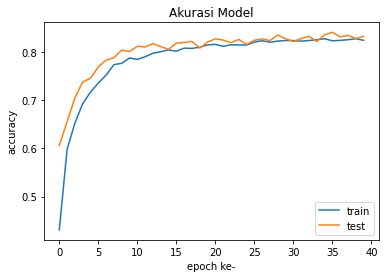

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch ke-')
plt.legend(['train', 'test'], loc = 'lower right')
plt.show()

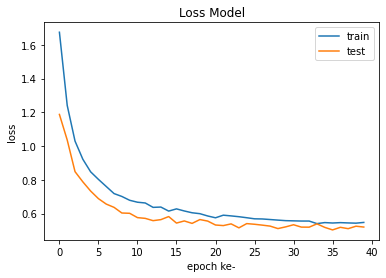

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch ke-')
plt.legend(['train', 'test'], loc = 'upper right')
plt.show()

In [ ]:
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [ ]:
tflite_model_file = pathlib.Path('animals.tflite')
tflite_model_file.write_bytes(tflite_model)

13003216